<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/content%2Fw2d5_tutorial_revs/tutorials/W2D5_ReinforcementLearning/student/W2D5_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 5, Tutorial 4
# From Reinforcement Learning to Planning

__Content creators:__ Marcelo Mattar and Eric DeWitt with help from Byron Galbraith

__Content reviewers:__ Matthew Krause and Michael Waskom

---

# Tutorial Objectives
  
In this tutorial you will implement one of the simplest model-based Reinforcement Learning algorithms, Dyna-Q. You will understand what a world model is, how it can improve the agent's policy, and the situations in which model-based algorithms are more advantagenous than their model-free counterparts.
    
* You will implement a model-based RL agent, Dyna-Q, that can solve a simple task;
* You will investigate the effect of planning on the agent's behavior;
* You will compare the behaviors of a model-based and model-free agent in light of an environmental change.

---
# Setup


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv

In [2]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
#@title Helper functions
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.
    
  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly 
  
  Returns:
    int: the chosen action
  """
  be_greedy = np.random.random() > epsilon
  if be_greedy:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q)) 

  return action


def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.
  
  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters
 
  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # value of previous state-action pair
  prev_value = value[int(state), int(action)]

  # maximum Q-value at current state
  if next_state is None or np.isnan(next_state):
      max_value = 0
  else:
      max_value = np.max(value[int(next_state)])

  # reward prediction error
  delta = reward + params['gamma'] * max_value - prev_value
  
  # update value of previous state-action pair
  value[int(state), int(action)] = prev_value + params['alpha'] * delta
  
  return value


def learn_environment(env, model_updater, planner, params, max_steps, 
                      n_episodes, shortcut_episode=None): 
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))
  
  # Run learning
  reward_sums = np.zeros(n_episodes)
  episode_steps = np.zeros(n_episodes)

  # Dyna-Q state
  model = np.nan*np.zeros((env.n_states, env.n_actions, 2))

  # Loop over episodes
  for episode in range(n_episodes):
    if shortcut_episode is not None and episode == shortcut_episode:
      env.toggle_shortcut()       
      state = 64
      action = 1
      next_state, reward = env.get_outcome(state, action)
      model[state, action] = reward, next_state
      value = q_learning(state, action, reward, next_state, value, params)
      

    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])
      
      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # sum rewards obtained
      reward_sum += reward
    
      # update value function
      value = q_learning(state, action, reward, next_state, value, params)

      # update model      
      model = model_updater(model, state, action, reward, next_state)
      # execute planner
      value = planner(model, value, params)
      
      if next_state is None:
        break  # episode ends
      state = next_state      
      
    reward_sums[episode] = reward_sum
    episode_steps[episode] = t+1
  
  return value, reward_sums, episode_steps


class world(object):
    def __init__(self):
        return

    def get_outcome(self):
        print("Abstract method, not implemented")
        return

    def get_all_outcomes(self):
        outcomes = {}
        for state in range(self.n_states):
            for action in range(self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes

class QuentinsWorld(world):
    """
    World: Quentin's world.
    100 states (10-by-10 grid world).
    The mapping from state to the grid is as follows:
    90 ...       99
    ...
    40 ...       49
    30 ...       39
    20 21 22 ... 29
    10 11 12 ... 19
    0  1  2  ...  9
    54 is the start state.
    Actions 0, 1, 2, 3 correspond to right, up, left, down.
    Moving anywhere from state 99 (goal state) will end the session.
    Landing in red states incurs a reward of -1.
    Landing in the goal state (99) gets a reward of 1.
    Going towards the border when already at the border will stay in the same
        place.
    """
    def __init__(self):
        self.name = "QuentinsWorld"
        self.n_states = 100
        self.n_actions = 4
        self.dim_x = 10
        self.dim_y = 10
        self.init_state = 54
        self.shortcut_state = 64
    
    def toggle_shortcut(self):
      if self.shortcut_state == 64:
        self.shortcut_state = 2
      else:
        self.shortcut_state = 64

    def get_outcome(self, state, action):
        if state == 99:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        reward = 0  # default reward value
        if action == 0:  # move right
            next_state = state + 1
            if state == 98:  # next state is goal state
                reward = 1
            elif state % 10 == 9:  # right border
                next_state = state
            elif state in [11, 21, 31, 41, 51, 61, 71,
                           12, 72,
                           73,
                           14, 74,
                           15, 25, 35, 45, 55, 65, 75]:  # next state is red
                reward = -1
        elif action == 1:  # move up
            next_state = state + 10
            if state == 89:  # next state is goal state
                reward = 1
            if state >= 90:  # top border
                next_state = state
            elif state in [2, 12, 22, 32, 42, 52, 62,
                           3, 63,
                           self.shortcut_state,
                           5, 65,
                           6, 16, 26, 36, 46, 56, 66]:  # next state is red
                reward = -1
        elif action == 2:  # move left
            next_state = state - 1
            if state % 10 == 0:  # left border
                next_state = state
            elif state in [17, 27, 37, 47, 57, 67, 77,
                           16, 76,
                           75,
                           14, 74,
                           13, 23, 33, 43, 53, 63, 73]:  # next state is red
                reward = -1
        elif action == 3:  # move down
            next_state = state - 10
            if state <= 9:  # bottom border
                next_state = state
            elif state in [22, 32, 42, 52, 62, 72, 82,
                           23, 83,
                           84,
                           25, 85,
                           26, 36, 46, 56, 66, 76, 86]:  # next state is red
                reward = -1
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward


# HELPER FUNCTIONS FOR PLOTTING

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions): 
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')
  

def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1
  
  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],      
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))  
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, env.dim_x)])  
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))      
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')
  

def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

---

# Section 1: Model-based RL

Video available at https://youtu.be/zT_legTotF0


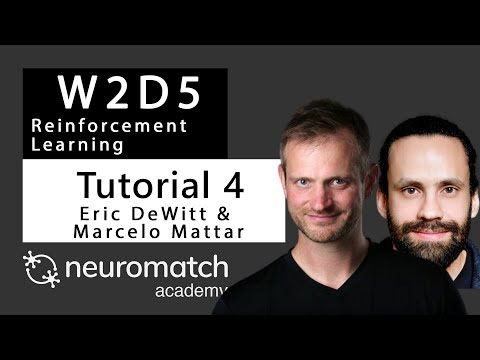

In [4]:
#@title Video 1: Model-based RL
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="zT_legTotF0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

The algorithms introduced in the previous tutorials are all *model-free*, as they do not require a model to use or control behavior. In this section, we will study a different class of algorithms called model-based. As we will see next, in contrast to model-free RL, model-based methods use a model to build a policy.

But what is a model? A model (sometimes called a world model or internal model) is a representation of how the world will respond to the agent's actions. You can think of it as a representation of how the world *works*. With such a representation, the agent can simulate new experiences and learn from these simulations. This is advantageous for two reasons. First, acting in the real world can be costly and sometimes even dangerous: remember Cliff World from Tutorial 3? Learning from simulated experience can avoid some of these costs or risks. Second, simulations make fuller use of one's limited experience. To see why, imagine an agent interacting with the real world. The information acquired with each individual action can only be assimilated at the moment of the interaction. In contrast, the experiences simulated from a model can be simulated multiple times -- and whenever desired -- allowing for the information to be more fully assimilated.

## Section 1.1 Quentin's World Environment

In this tutorial, our RL agent will act in the Quentin's world, a 10x10 grid world. 

<img alt="QuentinsWorld" width="560" height="560" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial4_QuentinsWorld.png?raw=true">

In this environment, there are 100 states and 4 possible actions: right, up, left, and down. The goal of the agent is to move, via a series of steps, from the start (green) location to the goal (yellow) region, while avoiding the red walls. More specifically:
* The agent starts in the green state,
* Moving into one of the red states incurs a reward of -1,
* Moving into the world borders stays in the same place,
* Moving into the goal state (yellow square in the upper right corner) gives you a reward of 1, and
* Moving anywhere from the goal state ends the episode.

Now that we have our environment and task defined, how can we solve this using a model-based RL agent?

---
# Section 2: Dyna-Q

In this section, we will implement Dyna-Q, one of the simplest model-based reinforcement learning algorithms. A Dyna-Q agent combines acting, learning, and planning. The first two components -- acting and learning -- are just like what we have studied previously. Q-learning, for example, learns by acting in the world, and therefore combines acting and learning. But a Dyna-Q agent also implements planning, or simulating experiences from a model--and learns from them. 

In theory, one can think of a Dyna-Q agent as implementing acting, learning, and planning simultaneously, at all times. But, in practice, one needs to specify the algorithm as a sequence of steps. The most common way in which the Dyna-Q agent is implemented is by adding a planning routine to a Q-learning agent: after the agent acts in the real world and learns from the observed experience, the agent is allowed a series of $k$ *planning steps*. At each one of those $k$ planning steps, the model generates a simulated experience by randomly sampling from the history of all previously experienced state-action pairs. The agent then learns from this simulated experience, again using the same Q-learning rule that you implemented for learning from real experience. This simulated experience is simply a one-step transition, i.e., a state, an action, and the resulting state and reward. So, in practice, a Dyna-Q agent learns (via Q-learning) from one step of **real** experience during acting, and then from k steps of **simulated** experience during planning.

There's one final detail about this algorithm: where does the simulated experiences come from or, in other words, what is the "model"? In Dyna-Q, as the agent interacts with the environment, the agent also learns the model. For simplicity, Dyna-Q implements model-learning in an almost trivial way, as simply caching the results of each transition. Thus, after each one-step transition in the environment, the agent saves the results of this transition in a big matrix, and consults that matrix during each of the planning steps. Obviously, this model-learning strategy only makes sense if the world is deterministic (so that each state-action pair always leads to the same state and reward), and this is the setting of the exercise below. However, even this simple setting can already highlight one of Dyna-Q major strengths: the fact that the planning is done at the same time as the agent interacts with the environment, which means that new information gained from the interaction may change the model and thereby interact with planning in potentially interesting ways.



Since you already implemented Q-learning in the previous tutorial, we will focus here on the extensions new to Dyna-Q: the model update step and the planning step. For reference, here's the Dyna-Q algorithm that you will help implement:

---
**TABULAR DYNA-Q**

Initialize $Q(s,a)$ and $Model(s,a)$ for all $s \in S$ and $a \in A$.

Loop forever:

> (a) $S$ &larr; current (nonterminal) state <br>
> (b) $A$ &larr; $\epsilon$-greedy$(S,Q)$ <br>
> (c) Take action $A$; observe resultant reward, $R$, and state, $S'$ <br>
> (d) $Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',a) - Q(S,A)\right]$ <br>
> (e) $Model(S,A)$ &larr; $R,S'$ (assuming deterministic environment) <br>
> (f) Loop repeat $k$ times: <br>
>> $S$ &larr; random previously observed state <br>
>> $A$ &larr; random action previously taken in $S$ <br>
>> $R,S'$ &larr; $Model(S,A)$ <br>
>> $Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',a) - Q(S,A)\right]$ <br>


---

## Exercise 1: Dyna-Q Model Update

In this exercise you will implement the model update portion of the Dyna-Q algorithm. More specifically, after each action that the agent executes in the world, we need to update our model to remember what reward and next state we last experienced for the given state-action pair.

In [5]:
def dyna_q_model_update(model, state, action, reward, next_state):
  """ Dyna-Q model update

  Args:    
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
  
  Returns:
    ndarray: the updated model
  """
  ###############################################################
  ## TODO for students: implement the model update step of Dyna-Q
  # Fill out function and remove
  raise NotImplementedError("Student exercise: implement the model update step of Dyna-Q")
  ###############################################################
  # Update our model with the observed reward and next state
  model[...] = ...

  return model

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial4_Solution_57268439.py)



Now that we have a way to update our model, we can use it in the planning phase of Dyna-Q to simulate past experiences.

## Exercise 2: Dyna-Q Planning

In this exercise you will implement the other key part of Dyna-Q: planning. We will sample a random state-action pair from those we've experienced, use our model to simulate the experience of taking that action in that state, and update our value function using Q-learning with these simulated state, action, reward, and next state outcomes. Furthermore, we want to run this planning step $k$ times, which can be obtained from `params['k']`.

For this exercise, you may use the `q_learning` function to handle the Q-learning value function update. Recall that the method signature is `q_learning(state, action, reward, next_state, value, params)` and it returns the updated `value` table.

In [7]:
def dyna_q_planning(model, value, params):
  """ Dyna-Q planning
  
  Args:    
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing learning parameters
 
  Returns:
    ndarray: the updated value function of shape (n_states, n_actions) 
  """
  ############################################################
  ## TODO for students: implement the planning step of Dyna-Q
  # Fill out function and remove
  raise NotImplementedError("Student exercise: implement the planning step of Dyna-Q")
  #############################################################
  # Perform k additional updates at random (planning)
  for _ in range(...):
    # Find state-action combinations for which we've experienced a reward i.e.
    # the reward value is not NaN. The outcome of this expression is an Nx2 
    # matrix, where each row is a state and action value, respectively.
    candidates = np.array(np.where(~np.isnan(model[:,:,0]))).T
    
    # Write an expression for selecting a random row index from our candidates
    idx = ...
    
    # Obtain the randomly selected state and action values from the candidates
    state, action = ...

    # Obtain the expected reward and next state from the model
    reward, next_state = ...
    
    # Update the value function using Q-learning
    value = ...
  
  return value

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial4_Solution_f242766e.py)



With a way to update our model and a means to use it in planning, it is time to see it in action. The following code sets up the our agent parameters and learning environment, then passes your model update and planning methods to the agent to try and solve Quentin's World. Notice that we set the number of planning steps $k=10$.

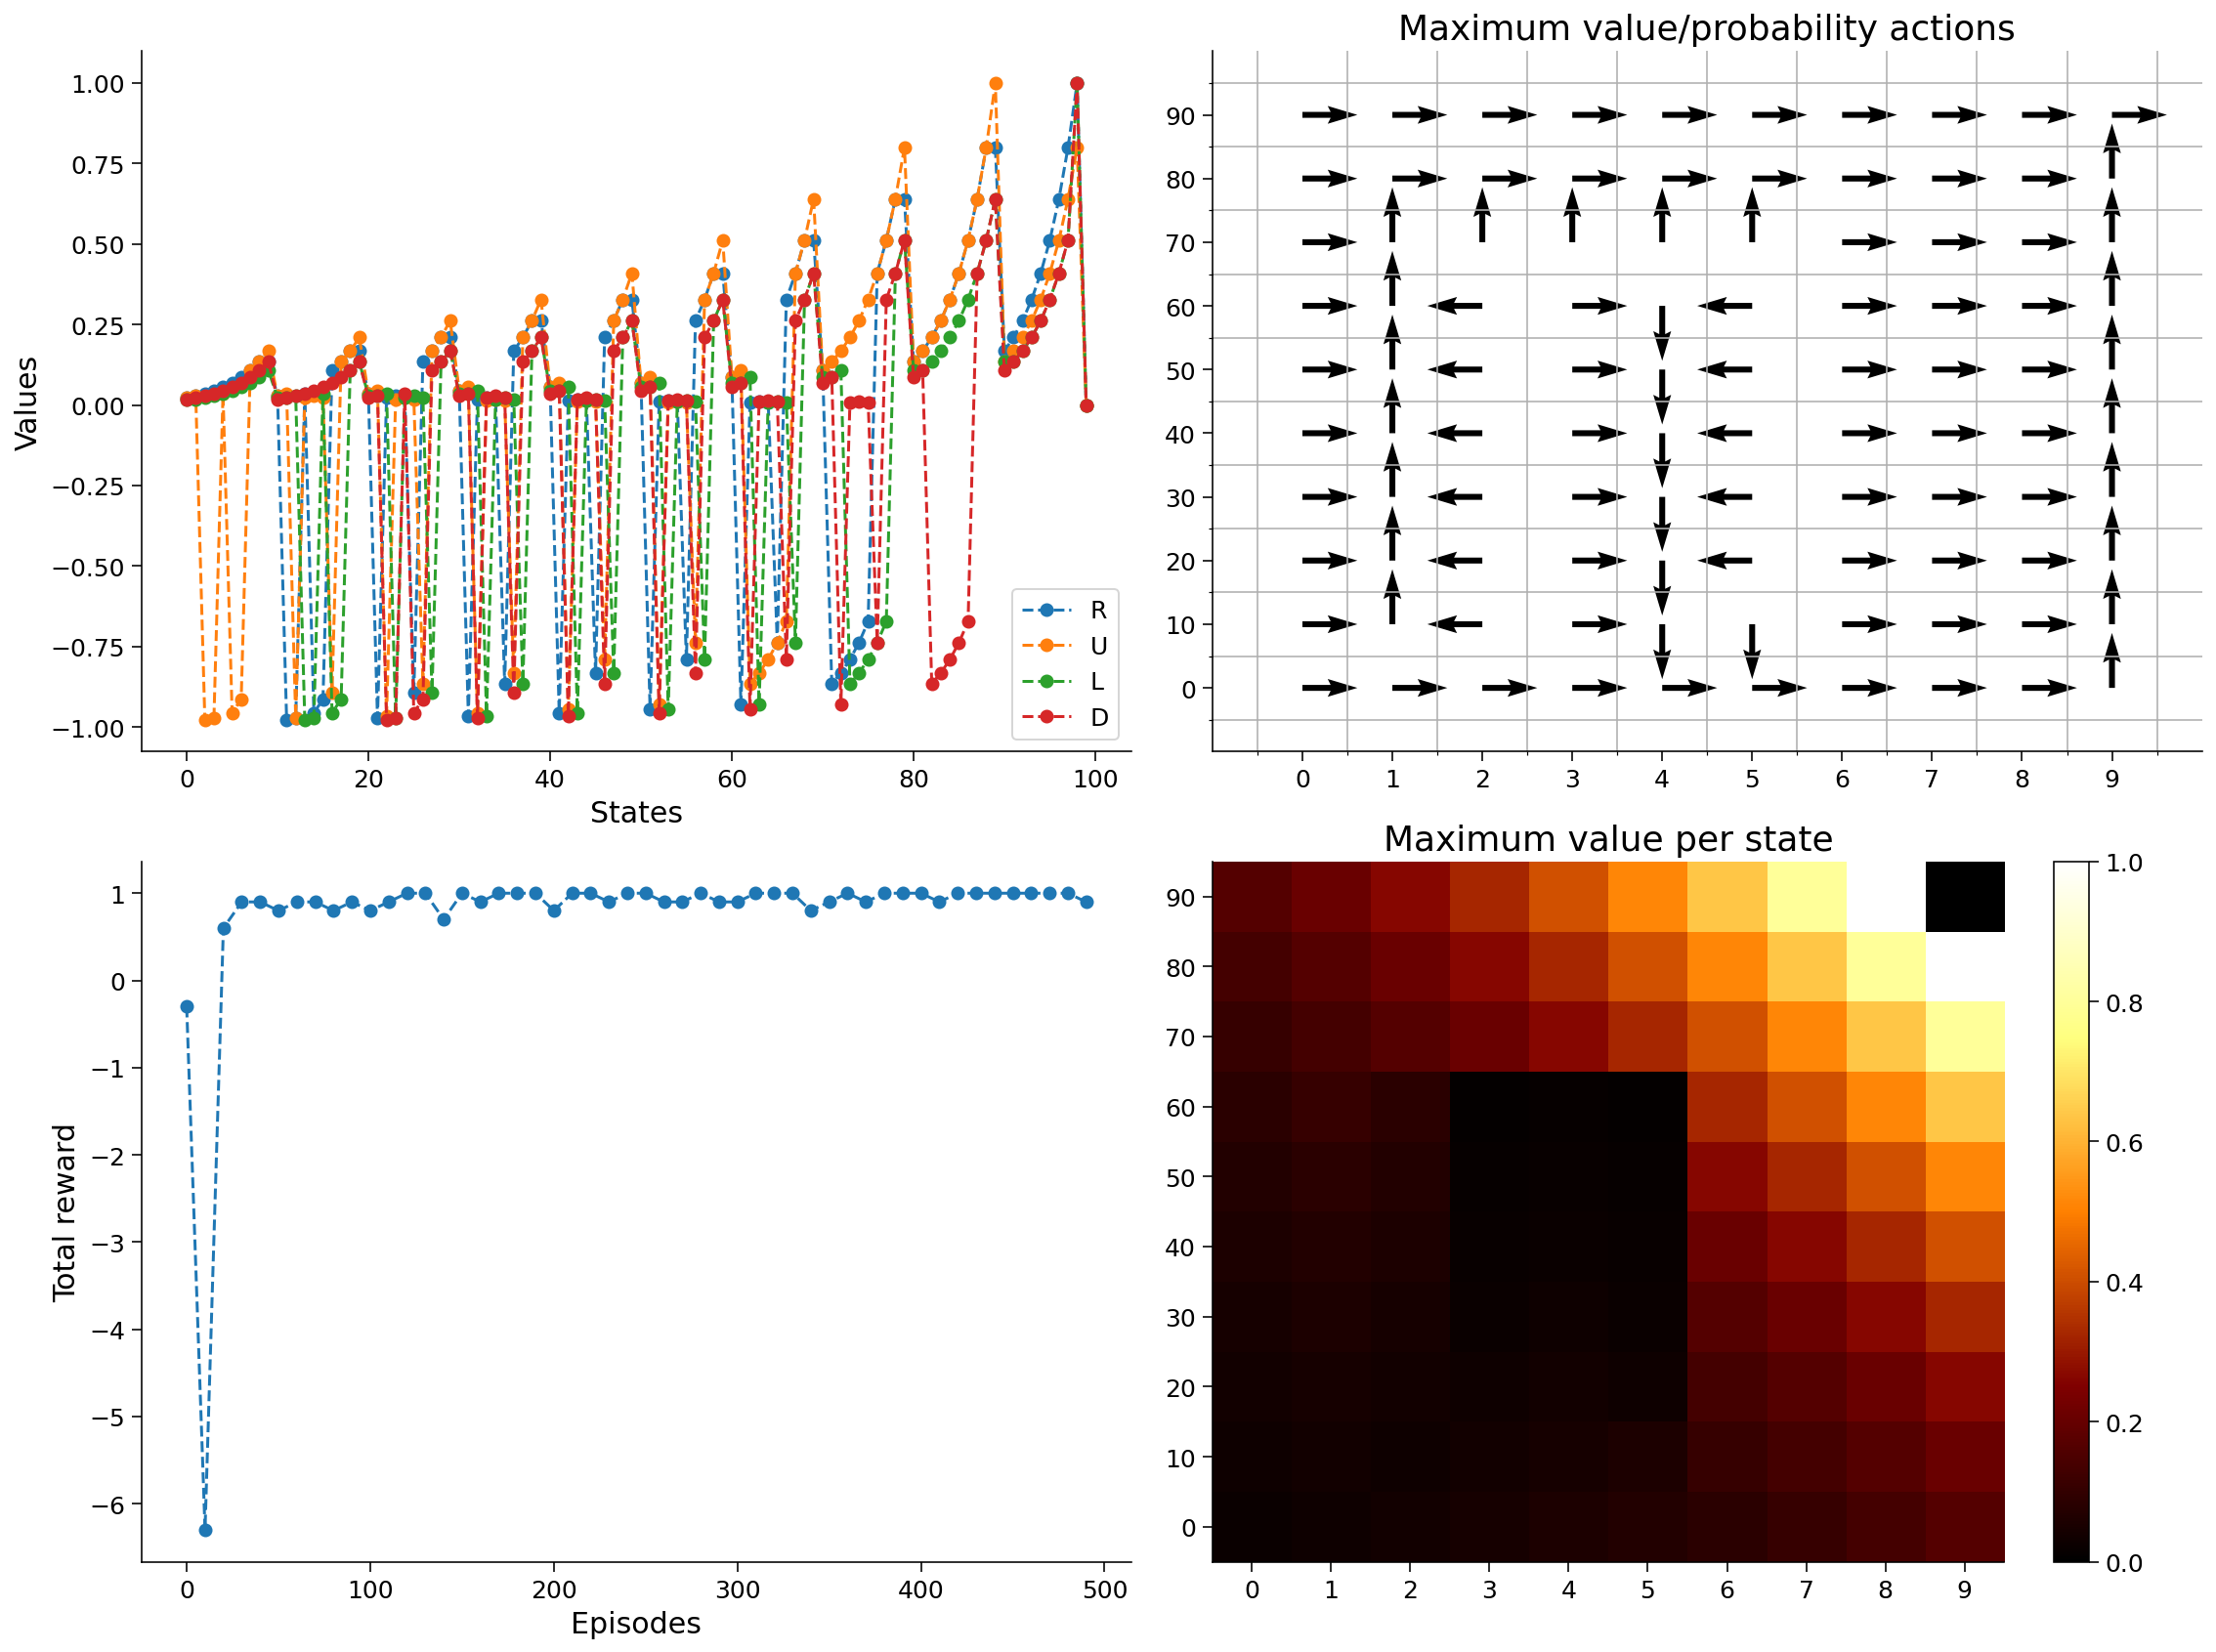

In [9]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate    
  'gamma': 0.8,  # temporal discount factor
  'k': 10,  # number of Dyna-Q planning steps
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = QuentinsWorld()

# solve Quentin's World using Dyna-Q
results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                            params, max_steps, n_episodes)
value, reward_sums, episode_steps = results

plot_performance(env, value, reward_sums)

Upon completion, we should see that our Dyna-Q agent is able to solve the task quite quickly, achieving a consistent positive reward after only a limited number of episodes (bottom left).

---
# Section 3: How much to plan?

Now that you implemented a Dyna-Q agent with $k=10$, we will try to understand the effect of planning on performance. How does changing the value of $k$ impact our agent's ability to learn?

The following code is similar to what we just ran, only this time we run several experiments over several different values of $k$ to see how their average performance compares. In particular, we will choose $k \in \{0, 1, 10, 100\}$. Pay special attention to the case where $k = 0$ which corresponds to no planning. This is, in effect, just regular Q-learning.

The following code will take a bit of time to complete. To speed things up, try lowering the number of experiments or the number of $k$ values to compare.

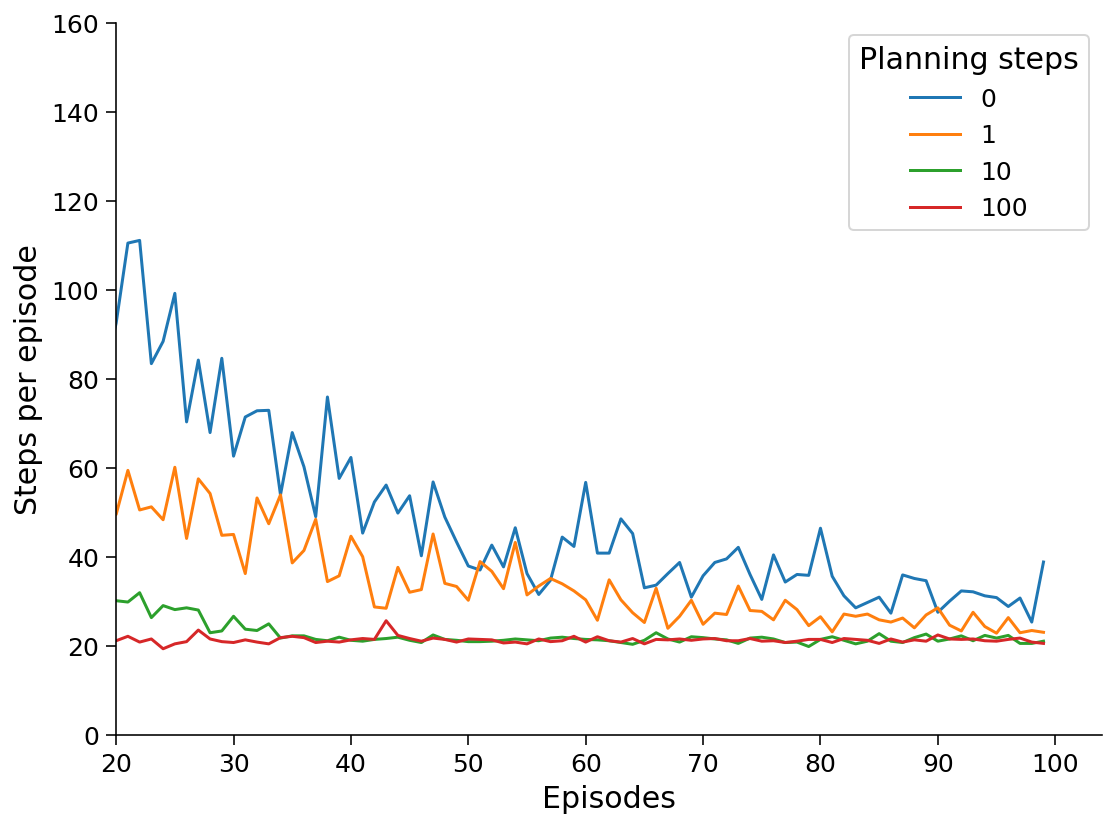

In [10]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate    
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_experiments = 10
n_episodes = 100
max_steps = 1000

# number of planning steps
planning_steps = np.array([0, 1, 10, 100])

# environment initialization
env = QuentinsWorld()

steps_per_episode = np.zeros((len(planning_steps), n_experiments, n_episodes))

for i, k in enumerate(planning_steps):
  params['k'] = k
  for experiment in range(n_experiments):
    results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                                params, max_steps, n_episodes)
    steps_per_episode[i, experiment] = results[2]

# Average across experiments
steps_per_episode = np.mean(steps_per_episode, axis=1)

# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episodes', ylabel='Steps per episode', 
       xlim=[20, None], ylim=[0, 160])
ax.legend(planning_steps, loc='upper right', title="Planning steps");

After an initial warm-up phase of the first 20 episodes, we should see that the number of planning steps has a noticable impact on our agent's ability rapidly solve the environment. We should also notice that after a certain value of $k$ our relative utility goes down, so it's important to balance a large enough value of $k$ that helps us learn quickly without wasting too much time in planning.

---
# Section 4: When the world changes...

In addition to speeding up learning about a new environment, planning can also help the agent to quickly incorporate new information about the environment into its policy. Thus, if the environment changes (e.g. the rules governing the transitions between states, or the rewards associated with each state/action), the agent doesn't need to experience that change *repeatedly* (as would be required in a Q-learning agent) in real experience. Instead, planning allows that change to be incorporated quickly into the agent's policy, without the need to experience the change more than once.

In this final section, we will again have our agents attempt to solve Quentin's World. However, after 200 episodes, a shortcut will appear in the environment.  We will test how a model-free agent using Q-learning and a Dyna-Q agent adapt to this change in the environment.

<img alt="QuentinsWorldShortcut" width="560" height="560" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial4_QuentinsWorldShortcut.png?raw=true">



The following code again looks similar to what we've run previously. Just as above we will have multiple values for $k$, with $k=0$ representing our Q-learning agent and $k=10$ for our Dyna-Q agent with 10 planning steps. The main difference is we now add in an indicator as to when the shortcut appears. In particular, we will run the agents for 400 episodes, with the shortcut appearing in the middle after episode #200.

When this shortcut appears we will also let each agent experience this change once i.e. we will evaluate the act of moving upwards when in the state that is below the now-open shortcut. After this single demonstration, the agents will continue on interacting in the environment.


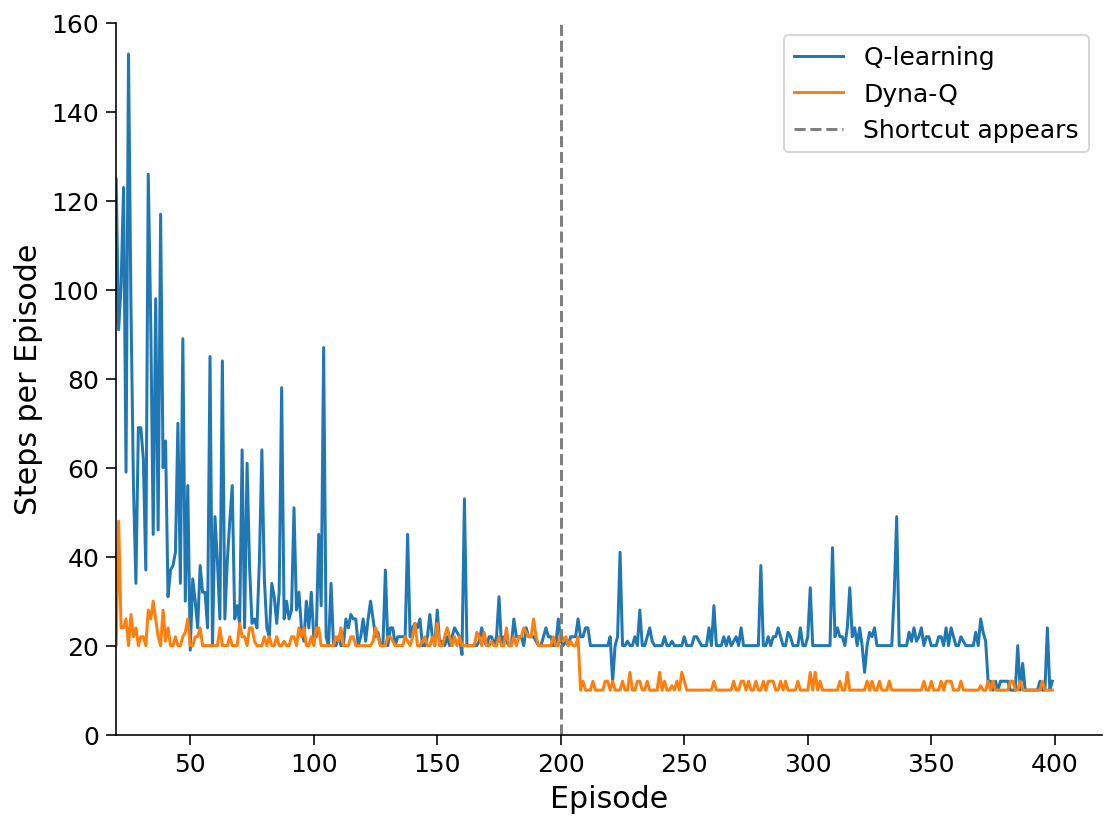

In [11]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate    
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_episodes = 400
max_steps = 1000
shortcut_episode = 200  # when we introduce the shortcut

# number of planning steps
planning_steps = np.array([0, 10]) # Q-learning, Dyna-Q (k=10)

# environment initialization
steps_per_episode = np.zeros((len(planning_steps), n_episodes))

# Solve Quentin's World using Q-learning and Dyna-Q
for i, k in enumerate(planning_steps):
  env = QuentinsWorld()
  params['k'] = k
  results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                              params, max_steps, n_episodes,
                              shortcut_episode=shortcut_episode)
  steps_per_episode[i] = results[2]


# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episode', ylabel='Steps per Episode',
       xlim=[20,None], ylim=[0, 160])
ax.axvline(shortcut_episode, linestyle="--", color='gray', label="Shortcut appears")
ax.legend(('Q-learning', 'Dyna-Q', 'Shortcut appears'), 
          loc='upper right');

If all went well, we should see the Dyna-Q agent having already achieved near optimal performance before the appearance of the shortcut and then immediately incorporating this new information to further improve. In this case, the Q-learning agent takes much longer to fully incorporate the new shortcut.

---
# Summary

In this notebook, you have learned about model-based reinforcement learning and implemented one of the simplest architectures of this type, Dyna-Q. Dyna-Q is very much like Q-learning, but instead of learning only from real experience, you also learn from **simulated** experience. This small difference, however, can have huge benefits! Planning *frees* the agent from the limitation of its own environment, and this in turn allows the agent to speed-up learning -- for instance,effectively incorporating environmental changes into one's policy.

Not surprisingly, model-based RL is an active area of research in machine learning. Some of the exciting topics in the frontier of the field involve (i) learning and representing a complex world model (i.e., beyond the tabular and deterministic case above), and (ii) what to simulate -- also known as search control -- (i.e., beyond the random selection of experiences implemented above).

The framework above has also been used in neuroscience to explain various phenomena such as planning, memory sampling, memory consolidation, and even dreaming!